In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


seed = 4
np.random.seed(seed)
torch.manual_seed(seed)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

if device.type == 'cpu':
    torch.set_num_threads(16)
    print(f"Limiting cpu threads to: {torch.get_num_threads()}")

Using cpu
Limiting cpu threads to: 16


In [2]:

# --- 3D Real-World Parameters ---
L_real = 2.0      # Beam length (m)
W_real = 1.0      # Beam width (m)
H_real = 1.0      # Beam height (m)

# For 3D beams, we use fundamental material properties E (Young's Modulus)
# and nu (Poisson's Ratio) instead of the composite term EI.
# We can derive E from your old EI value for consistency.
I_real = (W_real * H_real**3) / 12.0  # Moment of Inertia for rectangular cross-section
EI_real = 135245                     # Your original Flexural Rigidity
E_real = EI_real / I_real            # E = EI / I
nu_real = 0.3                        # Poisson's Ratio (a typical value)

# Force magnitudes
P_tip_real = 500  # N
P_mid_real = 300  # N

# --- Normalization for the New Problem ---
# We define characteristic length and force to make the problem unitless.
L_char = L_real
P_char = P_tip_real 

# Normalized dimensions and forces
L_norm = L_real / L_char # = 1.0
P_tip_norm = P_tip_real / P_char # = 1.0
P_mid_norm = P_mid_real / P_char # = 0.6

# Normalized Young's Modulus
# E is normalized by a characteristic stress (P_char / L_char^2)
E_norm = E_real / (P_char / L_char**2)

# --- Scale Factors for Un-normalization ---
x_scale = L_real
# The 1D w_scale remains a good estimate for the magnitude of deflection
w_scale = (P_char * L_real**3) / EI_real

# --- Define Neural Network for Euler-Bernoulli Theory ---
# The model now takes 1D position (x) and outputs 2D displacement (u, w).
# The network is shallower, as suggested by the paper for optimal performance[cite: 575, 576].
class PINN_Euler_Bernoulli(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 2)  # <-- CHANGED: Output for u and w
        )

    def forward(self, x):
        return self.net(x)

In [3]:
# Compute nth derivative (this function remains the same)
def get_derivative(y, x, n):
    for _ in range(n):
        y = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    return y

# --- New Energy-Based Loss Function (based on the paper) ---
def loss_fn_Euler_Bernoulli(model, x_interior, x_forces, P_forces, x_boundary, E_norm, W_real, H_real, L_real):
    """
    Energy-based loss using the paper's nonlinear Euler-Bernoulli theory.
    """
    
    # --- 1. Strain Energy (U) ---
    # First, calculate cross-sectional properties
    A = W_real * H_real         # Area
    I = (W_real * H_real**3) / 12 # Moment of Inertia
    
    x_interior.requires_grad = True
    displacement = model(x_interior) # Shape [N, 2]
    u = displacement[:, 0:1]         # Axial displacement
    w = displacement[:, 1:2]         # Transverse displacement

    # Get required derivatives for strain calculation
    du_dx = get_derivative(u, x_interior, 1)
    dw_dx = get_derivative(w, x_interior, 1)
    d2w_dx2 = get_derivative(w, x_interior, 2)

    # Calculate strain energy based on the paper's formulation[cite: 167].
    # The energy is integrated over the cross-section first, then the length.
    # The term (du_dx + 0.5 * dw_dx**2) represents nonlinear axial strain.
    # The term d2w_dx2 represents the strain from bending.
    strain_energy_per_length = 0.5 * E_norm * (
        A * (du_dx + 0.5 * dw_dx**2)**2 +
        I * (d2w_dx2)**2
    )
    
    # Total Strain Energy U is the integral over the beam's length
    strain_energy = torch.mean(strain_energy_per_length) * L_norm

    # --- 2. Work Potential (W) ---
    # Work is done by transverse forces on the transverse displacement 'w'
    w_at_forces = model(x_forces)[:, 1:2] # Select the 'w' component of the output
    work_potential = torch.sum(P_forces * w_at_forces)

    # --- 3. Boundary Conditions (BCs) at the fixed wall ---
    # For a clamped beam, u, w, and the slope dw/dx are all zero at x=0.
    x_boundary.requires_grad = True
    u0, w0 = model(x_boundary).chunk(2, dim=-1)
    dw0_dx = get_derivative(w0, x_boundary, 1)
    
    loss_bc = torch.mean(u0**2) + torch.mean(w0**2) + torch.mean(dw0_dx**2)

    # --- 4. Total Loss ---
    return strain_energy - work_potential + 5e4 * loss_bc # Added weight for stability

Epoch 100, Loss = 0.090331
Epoch 200, Loss = 0.017578
Epoch 300, Loss = 0.007285
Epoch 400, Loss = 0.005716
Epoch 500, Loss = 0.004954
Epoch 600, Loss = 0.004272
Epoch 700, Loss = 0.003625
Epoch 800, Loss = 0.003023
Epoch 900, Loss = 0.002477
Epoch 1000, Loss = 0.001993


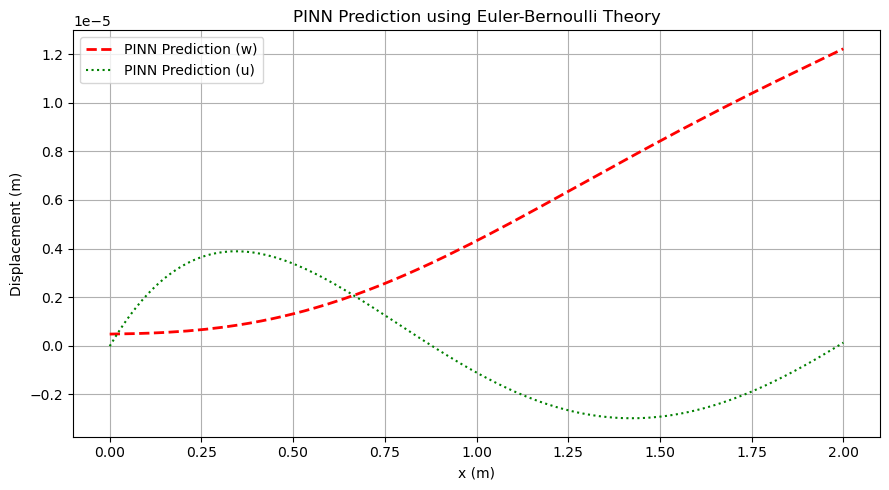

In [4]:
# --- Initialize ---
model = PINN_Euler_Bernoulli()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# --- Training Data (normalized domain) ---
x_forces = torch.tensor([[0.5], [L_norm]], requires_grad=True) # Midpoint and Tip
P_forces = torch.tensor([[P_mid_norm], [P_tip_norm]])
x_boundary = torch.tensor([[0.0]], requires_grad=True)
x_train = torch.linspace(0, L_norm, 100).view(-1, 1)

# --- Training Loop ---
# The paper uses many iterations; we use 5000 as a starting point[cite: 260].
for epoch in range(1000):
    optimizer.zero_grad()
    # Call the new loss function with all required arguments
    loss = loss_fn_Euler_Bernoulli(model, x_train, x_forces, P_forces, x_boundary, E_norm, W_real, H_real, L_real)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss = {loss.item():.6f}")

# --- Evaluation ---
x_eval_norm = torch.linspace(0, L_norm, 200).view(-1, 1)
with torch.no_grad():
    # Model now outputs two values: u and w
    displacement_pred_norm = model(x_eval_norm).numpy()

# Unscale for plotting
x_vals = x_eval_norm.numpy() * x_scale
u_pred = displacement_pred_norm[:, 0] * w_scale # Axial displacement
w_pred = displacement_pred_norm[:, 1] * w_scale # Transverse displacement

# --- Analytical Solution (for comparison with w) ---
def analytical_1D_solution(x_points, P_tip, P_mid, L, EI):
    w_tip = (P_tip * x_points**2) / (6 * EI) * (3 * L - x_points)
    a = L / 2.0
    w_mid_part1 = (P_mid * x_points**2) / (6 * EI) * (3 * a - x_points)
    w_mid_part2 = (P_mid * a**2) / (6 * EI) * (3 * x_points - a)
    w_mid = np.where(x_points <= a, w_mid_part1, w_mid_part2)
    return w_tip + w_mid

w_analytical = analytical_1D_solution(x_vals, P_tip_real, P_mid_real, L_real, EI_real)

# --- Plot ---
plt.figure(figsize=(9, 5))
#plt.plot(x_vals, w_analytical, 'k-', label='1D Analytical Solution (w)', linewidth=2.5)
plt.plot(x_vals, w_pred, 'r--', label="PINN Prediction (w)", linewidth=2)
plt.plot(x_vals, u_pred, 'g:', label="PINN Prediction (u)")
plt.xlabel("x (m)")
plt.ylabel("Displacement (m)")
plt.title("PINN Prediction using Euler-Bernoulli Theory")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

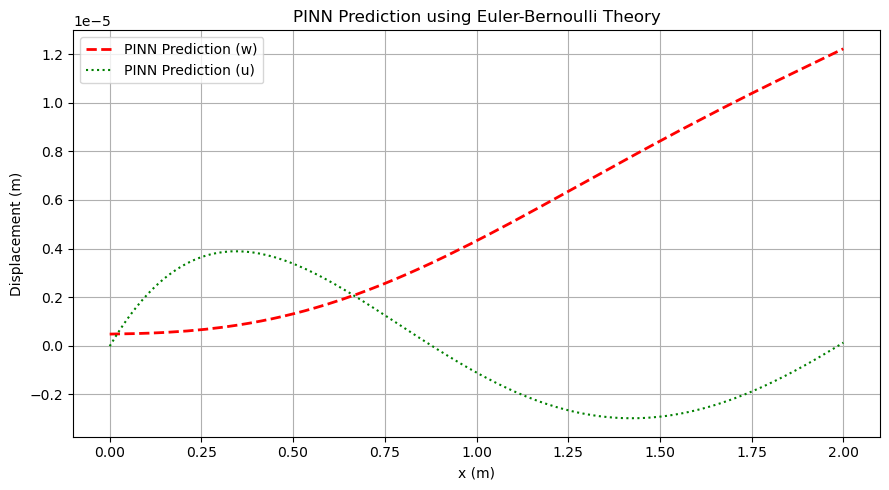

In [5]:
# --- Plot ---
plt.figure(figsize=(9, 5))
#plt.plot(x_vals, w_analytical, 'k-', label='1D Analytical Solution (w)', linewidth=2.5)
plt.plot(x_vals, w_pred, 'r--', label="PINN Prediction (w)", linewidth=2)
plt.plot(x_vals, u_pred, 'g:', label="PINN Prediction (u)")
plt.xlabel("x (m)")
plt.ylabel("Displacement (m)")
plt.title("PINN Prediction using Euler-Bernoulli Theory")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

r2 value = -2828579.915328212


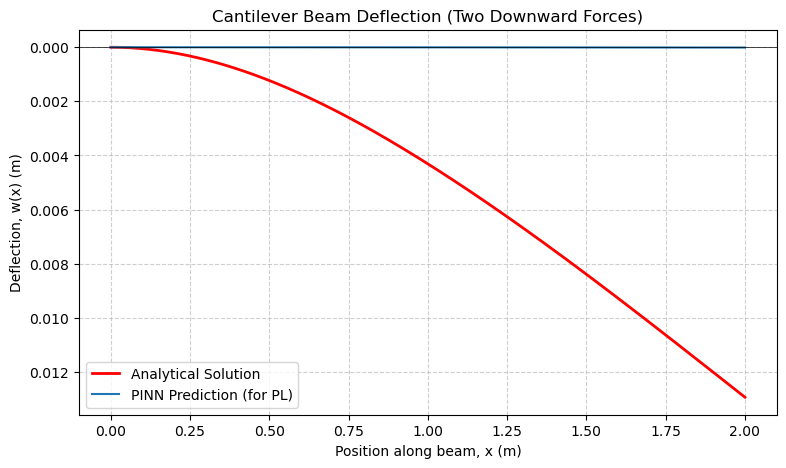


Maximum deflection at the tip (x=2.0m): 0.012939 m


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def analytical_solution(x_points, P_tip, P_mid, L, EI):
    """
    Calculates the analytical deflection of a cantilever beam with a tip load
    and a midpoint load using the principle of superposition.

    Args:
        x_points (np.ndarray): Points along the beam to calculate deflection.
        P_tip (float): Force at the tip of the beam (at x=L).
        P_mid (float): Force at the midpoint of the beam (at x=L/2).
        L (float): Length of the beam.
        EI (float): Flexural rigidity of the beam.

    Returns:
        np.ndarray: The deflection w(x) at each point in x_points.
    """
    # Deflection caused by the tip load P_tip
    w_tip = (P_tip * x_points**2) / (6 * EI) * (3 * L - x_points)

    # Deflection caused by the midpoint load P_mid (piecewise function)
    a = L / 2.0
    w_mid_part1 = (P_mid * x_points**2) / (6 * EI) * (3 * a - x_points)
    w_mid_part2 = (P_mid * a**2) / (6 * EI) * (3 * x_points - a)
    w_mid = np.where(x_points <= a, w_mid_part1, w_mid_part2)

    # The total deflection is the sum of the deflections from each load
    return w_tip + w_mid

# ==============================================================================
# Main script to run and plot the solution
# ==============================================================================
if __name__ == '__main__':
    # --- Beam Parameters ---
    L_real = 2.0      # Beam length (m)
    EI_real = 135245  # Flexural rigidity (N*m^2)
    P_tip_real = 500  # Point load at tip (N)
    P_mid_real = 500  # Point load at the midpoint (N)

    # --- Generate points for plotting ---
    x_values = np.linspace(0, L_real, 200)

    # --- Calculate the analytical solution ---
    w_analytical = analytical_solution(x_values, P_tip_real, P_mid_real, L_real, EI_real)

    r2_value = r2_score(w_pred, w_analytical)
    print(f"r2 value = {r2_value}")

    # --- Plot the results ---
    plt.figure(figsize=(9, 5))
    plt.plot(x_values, w_analytical, label='Analytical Solution', color='red', linewidth=2)
    plt.plot(x_vals, w_pred, label="PINN Prediction (for PL)")
    plt.title('Cantilever Beam Deflection (Two Downward Forces)')
    plt.xlabel('Position along beam, x (m)')
    plt.ylabel('Deflection, w(x) (m)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    # Invert y-axis to show downward deflection going down
    plt.gca().invert_yaxis()
    plt.axhline(0, color='black', linewidth=0.5)
    
    plt.show()

    # Print the maximum deflection value at the tip
    max_deflection = w_analytical[-1]
    print(f"\nMaximum deflection at the tip (x={L_real}m): {max_deflection:.6f} m")

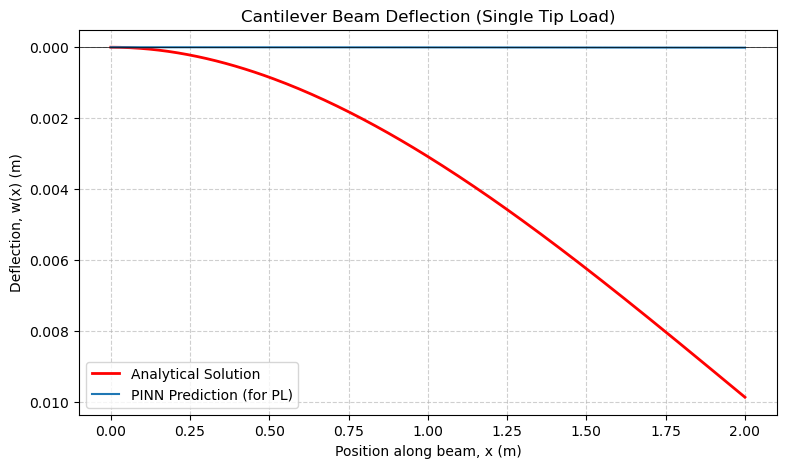


Maximum deflection at the tip (x=2.0m): 0.009859 m


In [7]:
def analytical_solution_tip_load(x_points, P, L, EI):
    """
    Calculates the analytical deflection of a cantilever beam with a single
    point load at the free end.

    Args:
        x_points (np.ndarray): Points along the beam to calculate deflection.
        P (float): Force at the tip of the beam (at x=L).
        L (float): Length of the beam.
        EI (float): Flexural rigidity of the beam.

    Returns:
        np.ndarray: The deflection w(x) at each point in x_points.
    """
    # Standard formula for deflection from a tip load
    w_analytical = (P * x_points**2) / (6 * EI) * (3 * L - x_points)
    
    return w_analytical

# ==============================================================================
# Main script to run and plot the solution
# ==============================================================================
if __name__ == '__main__':
    # --- Beam Parameters ---
    L_real = 2.0      # Beam length (m)
    EI_real = 135245  # Flexural rigidity (N*m^2)
    P_real = 500      # Point load at tip (N)

    # --- Generate points for plotting ---
    x_values = np.linspace(0, L_real, 200)

    # --- Calculate the analytical solution ---
    w_analytical = analytical_solution_tip_load(x_values, P_real, L_real, EI_real)

    # --- Plot the results ---
    plt.figure(figsize=(9, 5))
    plt.plot(x_values, w_analytical, label='Analytical Solution', color='red', linewidth=2)
    plt.plot(x_vals, w_pred, label="PINN Prediction (for PL)")
    plt.title('Cantilever Beam Deflection (Single Tip Load)')
    plt.xlabel('Position along beam, x (m)')
    plt.ylabel('Deflection, w(x) (m)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    # Invert y-axis to show downward deflection going down
    plt.gca().invert_yaxis()
    plt.axhline(0, color='black', linewidth=0.5)
    
    plt.show()

    # Print the maximum deflection value at the tip
    max_deflection = w_analytical[-1]
    print(f"\nMaximum deflection at the tip (x={L_real}m): {max_deflection:.6f} m")